In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

# Chapter 7 - ULYSSES’ COMPASS

## End of Chapter Problems

7E1. State the three motivating criteria that define information entropy. Try to express each in your
own words.

Answer: There are the usual desidirate which are given such as continuity, additivity etc. I think these are hard to imagine coming up with these desidirata in the first place unless you had a wild and strong intuition for what properties "information" really ought to have. I actually think the best motivation for this definition comes from the conclusion of Shannon's Source Coding Theorem which is roughly as follows: If we have a sample $\underline{X}_N$ of i.i.d random variables $X_i$ from a distribution F. If H is the entropy of the distribution F, then as the sample size $N \to \infty$, the number of binary digits required per symbol, to encode the sample with negligible probability of error is the same as the entropy.

7E2. Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads
70% of the time. What is the entropy of this coin?

Answer: $H(X) = -\sum_i P_i log(P_i)$

I'm using base 2 logarithm as it feels more natural (ironically) than the natural logarithm when it comes to information theory.
For the particular probability measure assigned to the coin in the question this becomes -0.7log(0.7) - 0.3log(0.3)

In [3]:
-0.7*np.log2(0.7) - 0.3*np.log2(0.3)

0.8812908992306927

Ie, less than one binary digit per coin flip is required when many coin flips are aggregated together.

7E3. Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

In [4]:
-0.2*np.log2(0.2) - 0.25*np.log2(0.25) - 0.25*np.log2(0.25) - 0.3*np.log2(0.3)

1.9854752972273344

This isn't far from an equiprobable die, therefore it's unsurprising that 2 bits of information are required. That is 2 bits of information can encode 4 states.

7E4. Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?

Answer: $3 \times -\frac{1}{3}log(\frac{1}{3}) = log(3)$

7M1. Write down and compare the definitions of AIC and WAIC. Which of these criteria is most
general? Which assumptions are required to transform the more general criterion into a less general
one?


$\text{AIC} = −2lppd + 2p$, and $\text{WAIC} = −2(lppd - \sum_i var_{\theta}[ log p(y_i|\theta) ])$

WAIC is more general and is less constrained than the AIC. The AC works on flat priors and assumes multivariate Gaussian behaviour of the posterior, and sample size is much greater than the number of parameters.

(To my current knowledge this all ties in with stuff relating to the Fisher information in the theory of maximum likelihoods)

7M2. Explain the difference between model selection and model comparison. What information is lost under model selection?

Answer: Model selection picks a single model from a set based upon some criterion, eg out of sample prediction accuracy or out of sample deviance, and picks the model that optimises that metric.

Model comparison on the other hand retains all models and uses their relative performance metrics to assess the contributions of certain variables to making predictions. It can then be used in conjunction with a causal model, and its implied conditional independencies to judge some causal claims. But information criterion alone are not enought to do this.

7M3. When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure.

Answer: Information criterion are calulated on in sample data. Changing the data would make this an unfair comparison.

Seeing as the information criterion are functions of -2𝑙𝑝𝑝𝑑, which is in turn an increasing function when more samples are added to the data, using different size data sets would yield an unfair comparison of the two models.

7M4. What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior
becomes more concentrated? Why? Perform some experiments, if you are not sure.


Answer: As the prior becomes narrower, the posterior becomes tighter for any given amount of data. Therefore, $\sum_i var_{\theta}[ log p(y_i|\theta) ]$ the variance on the penalty terms will become smaller. Why? Because as the posterior becomes narrower and narrower, the range of possible values of log p(y_i|\theta) will become smaller and smaller (Think of a dirac delta function as the reductio $\textit{ad absurdum}$ of this argument. In this case the variance becomes 0). Thus smaller prior, through a series of logical steps implied smaller variances in the sum and in turn a smaller "effective number of parameters"

7M5. Provide an informal explanation of why informative priors reduce overfitting.

Answer: Informative prior concentrate mass on some specified region of the parameter space. In this regime you're implicity giving preference to some parameters and asking the model to require more data to shift probability mass in the posterior. The more mass you concentrate in the prior, the more data you need to shift it.

7M6. Provide an informal explanation of why overly informative priors result in underfitting.

Answer: Concentrating all of the probabiliy mass in excess means that an overwhelming amount of data

7H1. In 2007, The Wall Street Journal published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in (reconstructed
at right), seemingly by hand, to make the argument that the relationship
between tax rate and tax revenue increases and then declines, such that
higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in data(Laffer). Consider models
that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a
straight-line model to any curved models you like. What do you conclude
about the relationship between tax rate and tax revenue?

In [5]:
# Load the data
Laffer = pd.read_csv("./data/Laffer.csv", delimiter=";")

<AxesSubplot:xlabel='tax_rate', ylabel='tax_revenue'>

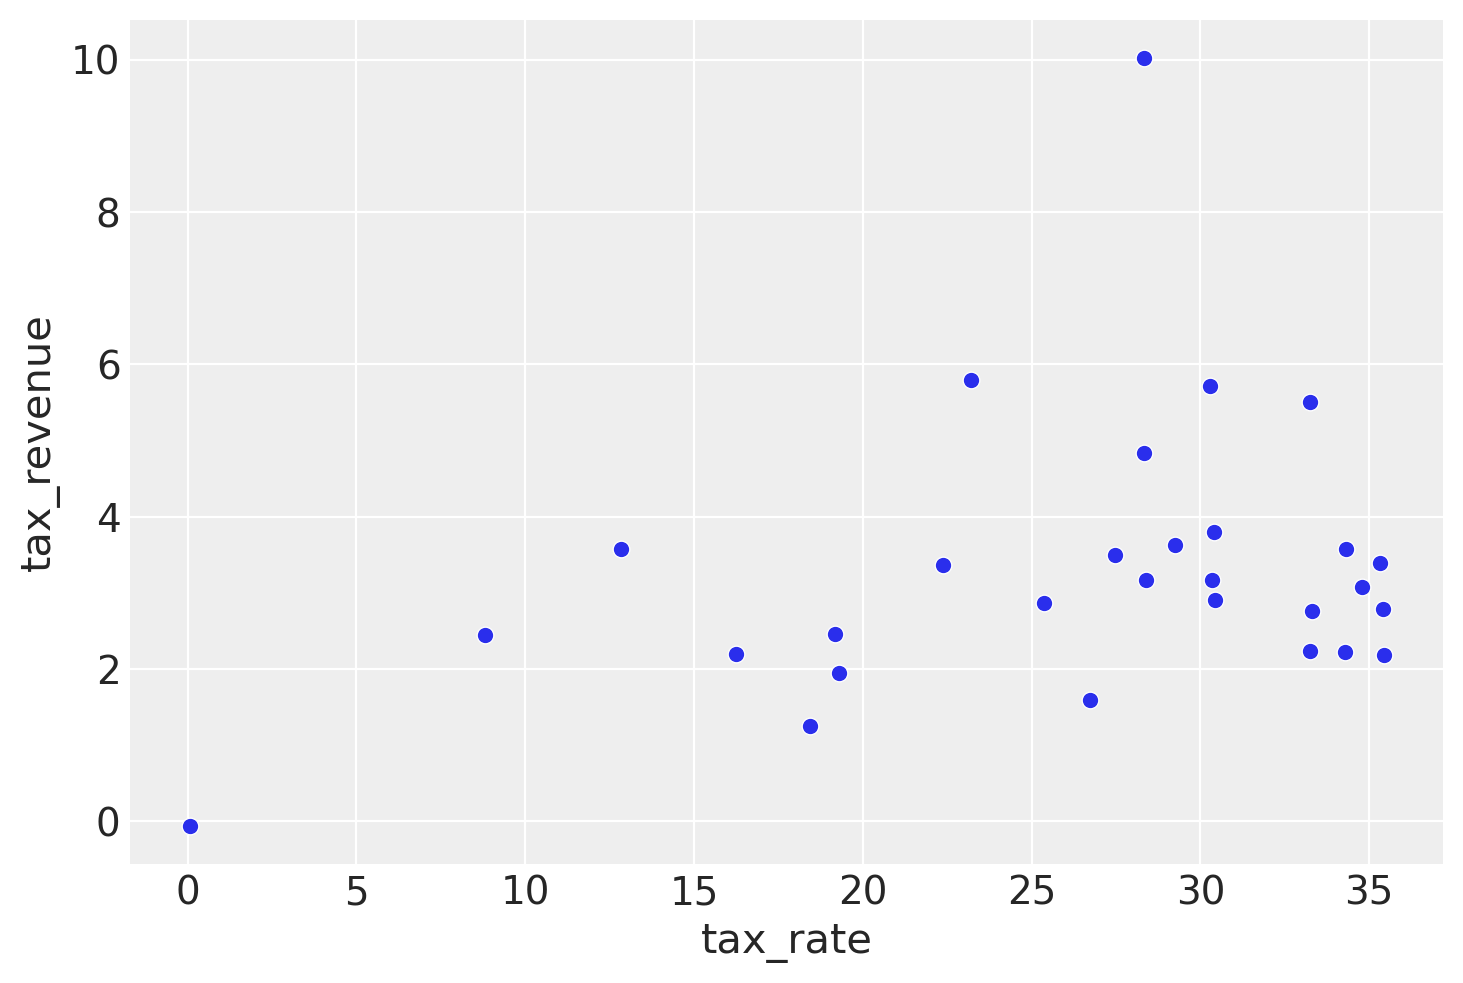

In [6]:
# plot it
sns.scatterplot(x="tax_rate", y="tax_revenue", data=Laffer)

Let's try 3 models for this data, each one a little a crazier than the last. I'll just fit polynomials from order 2, 3 and 5. This range of values ought to get the points across.

In [7]:
def standardise(x): return (x-np.mean(x))/np.std(x)

In [8]:
# standardise the data
Laffer["s_taxRate"] = standardise(Laffer.tax_rate)
Laffer["s_taxRevenue"] = standardise(Laffer.tax_revenue)

<AxesSubplot:xlabel='s_taxRate', ylabel='s_taxRevenue'>

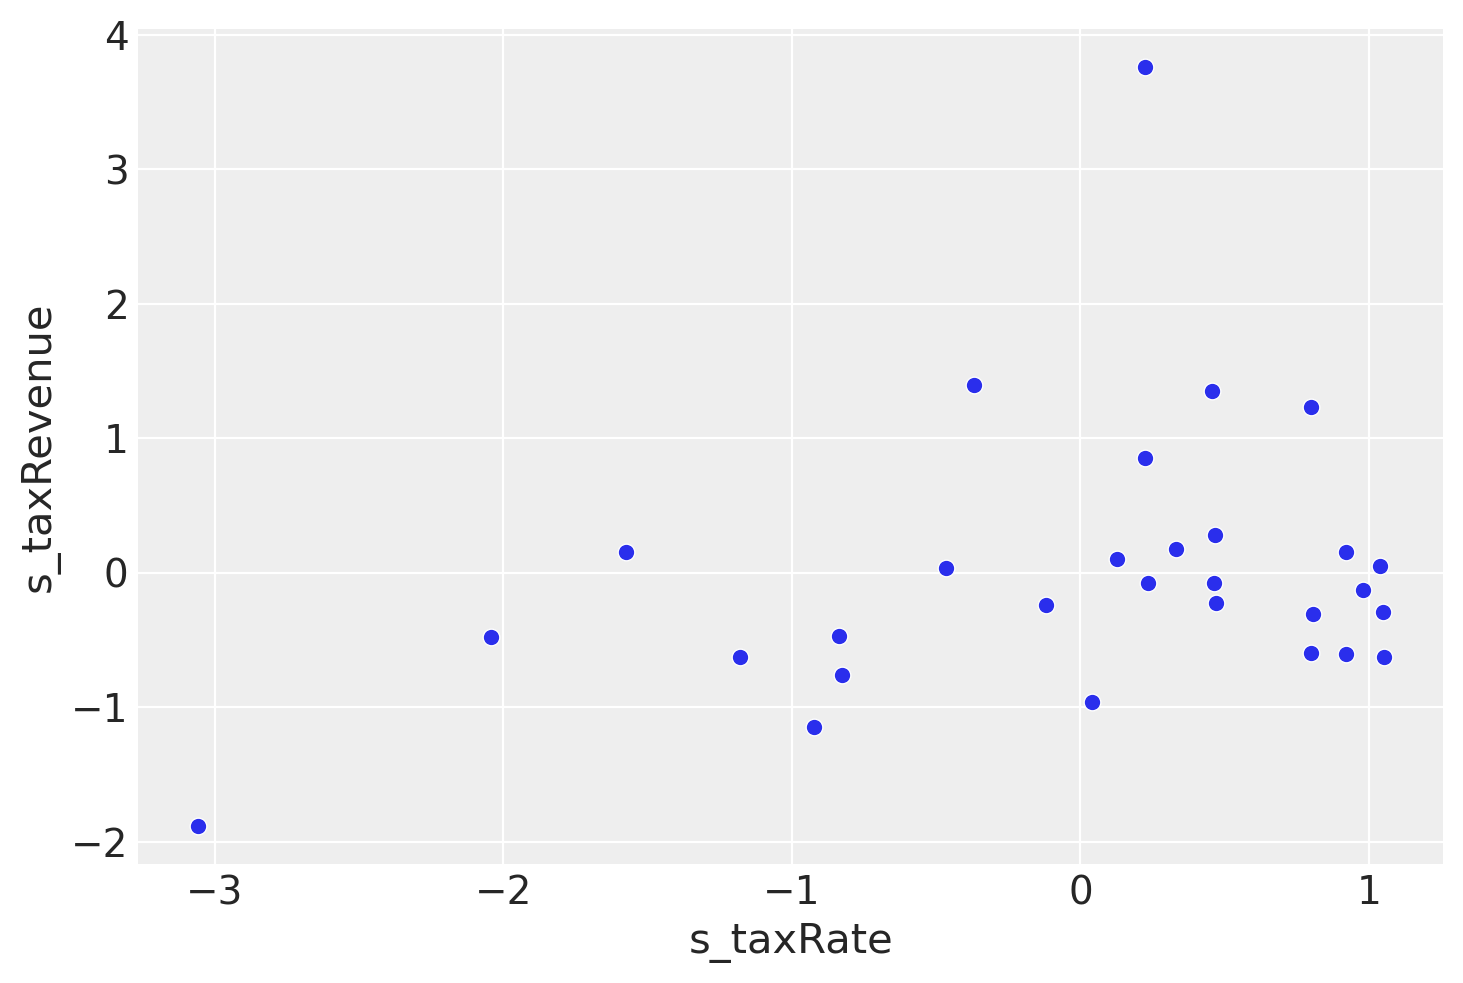

In [9]:
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer)

In [10]:
plt.fill

<function matplotlib.pyplot.fill(*args, data=None, **kwargs)>

In [11]:
np.linspace(2, 10, 9)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [12]:
# list of degrees of polynomials that we'll fit to the data
degree = np.linspace(1, 10, 10)
# get the data value to these powers and whack it in the data frame
powers = np.array([Laffer["s_taxRate"]**i for i in degree]).T
deg = []
for i in range(len(degree)):
    degr = "rate^" + str(degree[i])
    Laffer[degr] = powers[:, i]
    deg.append(degr)

In [13]:
# use pymc3 to fit 2,3 and 6 order polynomials to the data
with pm.Model() as first:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + beta*Laffer.s_taxRate
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    first_sample = pm.sample(draws=500, chains=4)

with pm.Model() as second:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5, shape=2)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + pm.math.dot(beta, Laffer[deg[:2]].values.T)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    second_sample = pm.sample(draws=500, chains=4)

with pm.Model() as third:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5, shape=3)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + pm.math.dot(beta, Laffer[deg[:3]].values.T)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    third_sample = pm.sample(draws=500, chains=4)

with pm.Model() as fourth:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5, shape=4)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + pm.math.dot(beta, Laffer[deg[:4]].values.T)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    fourth_sample = pm.sample(draws=500, chains=4)

with pm.Model() as seventh:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5, shape=7)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + pm.math.dot(beta, Laffer[deg[:7]].values.T)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    seventh_sample = pm.sample(draws=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 22 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8880819615912123, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5712391108324193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812107845144623, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 208 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7068684128166536, but should be close to 0.8. Try to increase the number of tuning steps.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
with pm.Model() as ninth:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5, shape=9)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + pm.math.dot(beta, Laffer[deg[:9]].values.T)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    ninth_sample = pm.sample(draws=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


RuntimeError: Chain 1 failed.

In [ ]:
def mean_curve(sample):
    coefficients = np.append(
        np.flip(np.mean(sample["beta"], axis=0)), np.mean(second_sample["alpha"]))
    return np.poly1d(coefficients)

The warnings above seem to indicate that the sampling procedure broke down for the fourth order polynomial. I won't trust the MCMC here and will learn how to fix this when I know more about MCMC. In the meantime I'm going to naively continue with the model comparison

In [ ]:
def first_line(x): return np.mean(
    first_sample["alpha"]) + np.mean(first_sample["beta"])*x

In [ ]:
def second_line(x): return np.mean(
    second_sample["alpha"]) + np.inner(np.mean(second_sample["beta"], axis=0), x)

In [ ]:
def third_line(x): return np.mean(
    third_sample["alpha"]) + np.inner(np.mean(third_sample["beta"], axis=0), x.T)

In [ ]:
def fourth_line(x): return np.mean(
    fourth_sample["alpha"]) + np.inner(np.mean(fourth_sample["beta"], axis=0), x.T)

In [ ]:
def seventh_line(x): return np.mean(
    seventh_sample["alpha"]) + np.inner(np.mean(seventh_sample["beta"], axis=0), x.T)

In [ ]:
np.mean(third_sample["beta"], axis=0)

In [ ]:
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer)
x = np.linspace(-3.1, 1.3)
plt.plot(x, mean_curve(first_sample)(x), label="first order")
plt.plot(x, mean_curve(second_sample)(x), label="second order")
plt.plot(x, mean_curve(third_sample)(x), label="third order")
plt.plot(x, mean_curve(fourth_sample)(x), label="Fourth order")
plt.plot(x, mean_curve(seventh_sample)(x), label="seventh order")
plt.plot(x, mean_curve(ninth_sample)(x), label="Ninth order")
# plt.plot(x,func(x),)
# plt.plot(x,third_line(np.array([x**2,x])),label="third order")
# plt.plot(x,fourth_line(np.array([x**4,x**3,x**2,x])),label="fourth order")
# plt.plot(x,seventh_line(np.array([x**7,x*6,x**5,x**4,x**3,x**2,x])),label="fourth order")
plt.legend()

In [ ]:
first_loo = pm.loo(first_sample, first, scale="deviance")
second_loo = pm.loo(second_sample, second, scale="deviance")
third_loo = pm.loo(third_sample, third, scale="deviance")
fourth_loo = pm.loo(fourth_sample, fourth, scale="deviance")
seventh_loo = pm.loo(seventh_sample, seventh, scale="deviance")
ninth_loo = pm.loo(ninth_sample, ninth, scale="deviance")

In [ ]:
psis = [first_loo.loo, second_loo.loo, third_loo.loo,
    fourth_loo.loo, seventh_loo.loo, ninth_loo.loo]

In [ ]:
psis_se = [first_loo.loo_se, second_loo.loo_se, third_loo.loo_se,
    fourth_loo.loo_se, seventh_loo.loo_se, ninth_loo.loo_se]

In [ ]:
"""
The deviance values
"""

first_waic = pm.waic(first_sample, first, scale="deviance")
second_wiac = pm.waic(second_sample, second, scale="deviance")
third_wiac = pm.waic(third_sample, third, scale="deviance")
fourth_wiac = pm.waic(fourth_sample, fourth, scale="deviance")
seventh_wiac = pm.waic(seventh_sample, seventh, scale="deviance")
ninth_waic = pm.waic(ninth_sample, ninth, scale="deviance")

In [ ]:
"""
Without deviance conversion
"""

# first_waic = pm.waic(first_sample, first)
# second_wiac = pm.waic(second_sample, second)
# third_wiac = pm.waic(third_sample, third)
# fourth_wiac = pm.waic(fourth_sample, fourth)
# seventh_wiac = pm.waic(seventh_sample, seventh)
# ninth_waic = pm.waic(ninth_sample, ninth)

In [ ]:
waics = [first_waic.waic, second_wiac.waic, third_wiac.waic,
    fourth_wiac.waic, seventh_wiac.waic, ninth_waic.waic]
waics

In [ ]:
waic_se = [first_waic.waic_se, second_wiac.waic_se, third_wiac.waic_se,
    fourth_wiac.waic_se, seventh_wiac.waic_se, ninth_waic.waic_se]

In [ ]:
orders = [1, 2, 3, 4, 7, 9]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(orders, psis)
axs[0].errorbar(orders, psis, psis_se)
axs[0].set_title("PSIS")
axs[0].set_xlabel("Paramater Numbers")
axs[1].set_title("WAIC")
axs[1].plot(orders, waics)
axs[1].set_xlabel("Paramater Numbers")
axs[1].errorbar(orders, waics, waic_se)
plt.show()

Both measures show that these polynomials don't behave horrendously different from one another. Admittedly, they give failry similar predictions by and large.

7H2. In the Laffer data, there is one country with a high tax revenue that is an outlier. Use PSIS
and WAIC to measure the importance of this outlier in the models you fit in the previous problem.
Then use robust regression with a Student’s t distribution to revisit the curve fitting problem. How
much does a curved relationship depend upon the outlier point?

Let's only investigate this for the linear relationship. I only want to learn about robust linear regression here. This should also overcome some of the warning errors about the k parameter in the pareto distribution to fit the outliers. They definitly aren't expected by a normal model.

In [ ]:
first_sample["alpha"] + np.outer(x, first_sample["beta"])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.2)
y = first_sample["alpha"] + np.outer(x, first_sample["beta"])
mean_line = np.mean(y, axis=1)
intervals = pm.hpd(y.T)


axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=first_loo.loo_i.values, ax=axs[0])
axs[0].plot(x, mean_line)
axs[0].fill_between(x, intervals[:, 0], intervals[:, 1], alpha=0.3)

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=first_waic.waic_i.values, ax=axs[1])
axs[1].plot(x, mean_line)
axs[1].fill_between(x, intervals[:, 0], intervals[:, 1], alpha=0.3)

# plt.scatter(Laffer.s_taxRate,first_waic.waic_i.values, label="WAIC")

plt.show()

Now we'll train a robust linear regression using a student-t error model for the data, instead of the usual Gaussian jazz.

In [ ]:
with pm.Model() as robust_first:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.5)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = alpha + beta*Laffer.s_taxRate
    rev = pm.StudentT("rev", 2, mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    robust_first_sample = pm.sample(draws=500, chains=4)

In [ ]:
robust_first_loo = pm.loo(robust_first_sample, robust_first, scale="deviance")
robust_first_waic = pm.waic(
    robust_first_sample, robust_first, scale="deviance")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.2)
y = robust_first_sample["alpha"] + np.outer(x, robust_first_sample["beta"])
mean_line = np.mean(y, axis=1)
intervals = pm.hpd(y.T)

plt.suptitle("Robust linear regression")

axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=robust_first_loo.loo_i.values, ax=axs[0])
axs[0].plot(x, mean_line)
axs[0].fill_between(x, intervals[:, 0], intervals[:, 1], alpha=0.3)

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=robust_first_waic.waic_i.values, ax=axs[1])
axs[1].plot(x, mean_line)
axs[1].fill_between(x, intervals[:, 0], intervals[:, 1], alpha=0.3)

# plt.scatter(Laffer.s_taxRate,first_waic.waic_i.values, label="WAIC")

plt.show()

As can be seen, the difference in size betwen the outlier values and the more expected values is less stark for the robust linear regression. Intuitively one might think of this as being something like the robust linear regression are more prepared for/expect the outlier events to occur. This is captured in the student-t used in the likelihood.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Standard Linear regression")
pm.forestplot(first_sample, ax=axs[0])
axs[1].set_title("Robust Linear regression")
pm.forestplot(robust_first_sample, ax=axs[1])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.2)
y1 = first_sample["alpha"] + np.outer(x, first_sample["beta"])
mean_line1 = np.mean(y1, axis=1)
intervals1 = pm.hpd(y1.T)

y2 = robust_first_sample["alpha"] + np.outer(x, robust_first_sample["beta"])
mean_line2 = np.mean(y2, axis=1)
intervals2 = pm.hpd(y.T)

axs[0].set_title("Standard regression compared to robust")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=first_loo.loo_i.values, ax=axs[0])
axs[0].plot(x, mean_line1, label="Standard Regression")
axs[0].plot(x, mean_line2, label="Robust Regression")
axs[0].legend()
# axs[0].fill_between(x,intervals[:,0],intervals[:,1],alpha = 0.3)

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer,
                size=robust_first_waic.waic_i.values, ax=axs[1])
axs[1].plot(x, mean_line1)
axs[1].plot(x, mean_line2)
# axs[1].fill_between(x,intervals[:,0],intervals[:,1],alpha = 0.3)

# plt.scatter(Laffer.s_taxRate,first_waic.waic_i.values, label="WAIC")

plt.legend()
plt.show()

As can be seen, using the robust linear regression does change the model somewhat. But I wouldn't say it's been an overwhelming change in the model. This is because straight forward linear regression was fairly robust for this data anyway.

| Island |Species A | Species B | Species C | Species D | Species E |
| --- | --- | --- |  --- | --- | --- |
|Island 1| 0.2 | 0.2 | 0.2 | 0.2 | 0.2 |

7H3. Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by
the king with surveying the bird population. They have each found the following proportions of 5
important bird species:


| Island |Species A | Species B | Species C | Species D | Species E |
| --- | --- | --- |  --- | --- | --- |
|Island 1| 0.2 | 0.2 | 0.2 | 0.2 | 0.2 |
|Island 2| 0.8| 0.1| 0.05| 0.025| 0.025|
|Island 3 |0.05 |0.15 |0.7 |0.05 |0.05|


Notice that each row sums to 1, all the birds. This problem has two parts. It is not computationally
complicated. But it is conceptually tricky. First, compute the entropy of each island’s bird distribution.
Interpret these entropy values. Second, use each island’s bird distribution to predict the other two.
This means to compute the KL divergence of each island from the others, treating each island as if it
were a statistical model of the other islands. You should end up with 6 different KL divergence values.
Which island predicts the others best? Why?

Answer:

Island1 :=  H = log(5)

In [ ]:
np.log2(5)

Island2 :=

In [ ]:
-0.8*np.log2(0.8) - 0.1*np.log2(0.1) - 0.05*np.log2(0.05) - 0.05*np.log(0.025)

In [ ]:
# speeding things up a bit
p3 = np.array([0.05, 0.15, 0.7, 0.05, 0.05])
-np.inner(p3, np.log2(p3))

In [ ]:
p1 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
p2 = np.array([0.8, 0.1, 0.05, 0.025, 0.025])
dists = [p1, p2, p3]

These are the information entropies for the bird species given that you're in a specific Island, which is roughly how uncertain you are about what species of bird the next bird you encounter will be.

In [ ]:
p1/p2

To compute the KL divergence $D_{KL}(P||Q) = \sum P_i log(\frac{P_i}{Q_i})$

In [ ]:
np.inner(p, np.log2(p/q)) for p in dists for q in dists]).reshape(3, 3)

In [ ]:
divergence_pairs=np.array([np.inner(p, np.log2(p/q))
                          for p in dists for q in dists]).reshape(3, 3)

In [ ]:
A="abc"
B="cde"

In [ ]:
np.array([p+q for p in A for q in B]).reshape(3, 3)

In [ ]:
fig =plt.figure(figsize = (5, 5))
labels=[1, 2, 3]
ax=fig.add_subplot(111)  # define axis, so we can modify
im=ax.imshow(divergence_pairs)   # display the matrix
ax.set_xticks(np.arange(len(labels)))  # show them all!
ax.set_yticks(np.arange(len(labels)))  # show them all!
ax.set_xticklabels(labels)  # set to be the abbv (vs useless #)
ax.set_yticklabels(labels)
fig.colorbar(im,  shrink= 0.8)
plt.xlabel("Q distribution")
plt.ylabel("P distribution")
plt.show()

As can be seen from the heatmap of divergence pairs in the figure above, all distributions have zero divergence from themselves. This is the zero diagonal. Distributions of Islands 1 and 3 model each other fairly well,as the probability masses assigned or not radically different. Using Island 2's disstribution to model Island 3 would be bad. This is because on Island 2 you would never expect to see species C, whilst on Island 3 species C is fairly common. This someone from Island 2 on Island 3 would be consistently surprised by the regular occurence of species C that they were observing. In contrast to this someone from Island 3 on Island 2 would always be astonished by the regular occurence of species A birds that they were observing.

Mean while all other directional pairs of distribution divergence is relatively low. All the bird pair frequencies are of comparable frequencies, at least in terms of their order of magnitude of occurence, and you would never be obviously suprised by how often this different occurences were taking place.

7H4. Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models
m6.9 and m6.10 again (page 178). Compare these two models usingWAIC (or PSIS, they will produce
identical results). Which model is expected to make better predictions? Which model provides the
correct causal inference about the influence of age on happiness? Can you explain why the answers
to these two questions disagree?

In [ ]:
# load the data up
Waffle=pd.read_csv("./data/WaffleDivorce.csv", delimiter = ";")

I stole the below code from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb.

It generates the data. There's not autodidactic value to implementing this yourself.

In [ ]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years= 100, seed = 1234):
    np.random.seed(seed)

    popn=pd.DataFrame(np.zeros((20 * 65, 3)), columns = ["age", "happiness", "married"])
    popn.loc[: , "age"] = np.repeat(np.arange(65), 20)
    popn.loc[: , "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[: , "married"].values, dtype = "bool")

    for i in range(N_years):
        # age population
        popn.loc[: , "age"] += 1
        # replace old folk with new folk
        ind=popn.age == 65
        popn.loc[ind, "age"]=0
        popn.loc[ind, "married"]=False
        popn.loc[ind, "happiness"]=np.linspace(-2, 2, 20)

        # do the work
        elligible=(popn.married == 0) & (popn.age >= 18)
        marry=(
            np.random.binomial(1, inv_logit(
                popn.loc[elligible, "happiness"] - 4)) == 1
        )
        popn.loc[elligible, "married"]=marry

    popn.sort_values("age", inplace= True, ignore_index = True)

    return popn

In [ ]:
popn=sim_happiness()

popn_summ=popn.copy()
popn_summ["married"]=popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind= "stats", round_to = 2)

In [ ]:
popn["s_age"]=standardise(popn.age)
popn["s_happiness"]=standardise(popn.happiness)

In [ ]:
# set up the two multiple regression models

# This model includes marital status
with pm.Model() as m6_9:
    alpha =pm.Normal("alpha", 0, 1, shape = 2)
    beta=pm.Normal("beta", 0, 2)
    sigma=pm.Exponential("sigma", 1)
    mu=alpha[popn.married + 0] + beta*popn.s_age
    Happy=pm.Normal("Happy", mu, sd = sigma, observed = popn.s_happiness)
    m6_9Sample =pm.sample(draws = 1000, chains = 4)

# This model ignores marital status
with pm.Model() as m6_10:
    alpha=pm.Normal("alpha", 0, 1)
    beta=pm.Normal("beta", 0, 2)
    sigma=pm.Exponential("sigma", 1)
    mu=alpha + beta*popn.s_age
    Happy=pm.Normal("Happy", mu, sd = sigma, observed = popn.s_happiness)
    m6_10Sample =pm.sample(draws = 1000, chains = 4)

In [ ]:
fig, axs=plt.subplots(1, 2, figsize = (15, 5))

axs[0].set_title("Standard Linear regression")
pm.forestplot(m6_9Sample, ax= axs[0])
axs[1].set_title("Robust Linear regression")
pm.forestplot(m6_10Sample, ax= axs[1])
plt.show()

In [ ]:
# set the line equations up
single_line=np.poly1d([np.mean(m6_9Sample["beta"]),
                      np.mean(m6_9Sample["alpha"][:, 0])])
marrid_line=np.poly1d([np.mean(m6_9Sample["beta"]),
                      np.mean(m6_9Sample["alpha"][:, 1])])

In [ ]:
x1=np.linspace(-1.7, 1.7)

plt.plot(x1, marrid_line(x1), label= "Married")
plt.scatter(popn[popn.married == True].s_age, popn[popn.married == True].s_happiness, alpha= 0.3)
plt.scatter(popn[popn.married == False].s_age, popn[popn.married == False].s_happiness, alpha= 0.3)
plt.plot(x1, single_line(x1), label= "Single")
plt.xlabel("Age")
plt.ylabel("Happiness")
plt.legend()

In [ ]:
waic_m6_9  = pm.waic(m6_9Sample, pointwise = True, scale = "deviance")
waic_m6_10  = pm.waic(m6_10Sample, pointwise = True, scale = "deviance")

In [ ]:
# print the deviance
waic_m6_9.waic, waic_m6_10.waic

In [ ]:
# get the standard error
waic_m6_9.waic_se, waic_m6_10.waic_se

The waic is considerably smaller for model 3.9, the false model. This is a false causal model, as conditioning on marriage is an example of collider bias in the model. However it has a lower deviance, greater predictive power than the true causal model, as knowing whether you're married offers great insight about whether or not you're happy, as it's caused by happiness rather than causing it in the model laid out above.

7H5. Revisit the urban fox data, data(foxes), from the previous chapter’s practice problems. Use
WAIC or PSIS based model comparison on five different models, each using weight as the outcome,
and containing these sets of predictor variables:

(1) avgfood + groupsize + area

(2) avgfood + groupsize

(3) groupsize + area

(4) avgfood

(5) area

Can you explain the relative differences in WAIC scores, using the fox DAG from the previous chapter? Be sure to pay attention to the standard error of the score differences (dSE).

In [ ]:
Foxy=pd.read_csv("./data/foxes.csv", delimiter = ";")

In [ ]:
# standardise all variables
for column in Foxy.columns.values:
    Foxy["s_" + column]=standardise(Foxy[column])

In [ ]:
Foxy.iloc[: , 6: 9]

In [ ]:
with pm.Model() as model1:
    alpha=pm.Normal("alpha", 0, 1)
    beta =pm.Normal("beta", 0, 1, shape = 3)
    sigma=pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 6: 9].values, beta)
    Weight=pm.Normal("Weight", mu, sd= sigma, observed = Foxy.weight)
    m1Sample=pm.sample(draws = 1000, chains = 4)

with pm.Model() as model2:
    alpha=pm.Normal("alpha", 0, 1)
    beta =pm.Normal("beta", 0, 1, shape = 2)
    sigma=pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 6: 8].values, beta)
    Weight=pm.Normal("Weight", mu, sd= sigma, observed = Foxy.weight)
    m2Sample=pm.sample(draws = 1000, chains = 4)

with pm.Model() as model3:
    alpha=pm.Normal("alpha", 0, 1)
    beta =pm.Normal("beta", 0, 1, shape = 2)
    sigma=pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 7: 9].values, beta)
    Weight=pm.Normal("Weight", mu, sd= sigma, observed = Foxy.weight)
    m3Sample=pm.sample(draws = 1000, chains = 4)

with pm.Model() as model4:
    alpha=pm.Normal("alpha", 0, 1)
    beta=pm.Normal("beta", 0, 1)
    sigma=pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[: , 6].values, beta)
    Weight=pm.Normal("Weight", mu, sd= sigma, observed = Foxy.weight)
    m4Sample=pm.sample(draws = 1000, chains = 4)

with pm.Model() as model5:
    alpha=pm.Normal("alpha", 0, 1)
    beta=pm.Normal("beta", 0, 1)
    sigma=pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[: , 8].values, beta)
    Weight=pm.Normal("Weight", mu, sd= sigma, observed = Foxy.weight)
    m5Sample=pm.sample(draws = 1000, chains = 4)

In [ ]:
# compare these models with
compare_df=az.compare(
    {"model1": m1Sample, "model2": m2Sample, "model3": m3Sample,
        "model4": m4Sample, "model5": m5Sample},
     method = "pseudo-BMA",
    ic = "waic",
    scale = "deviance",
)
compare_df

In [ ]:
az.plot_compare(compare_df);

It can be seen that the two simplest models have the largest deviances, showing that they lose a lot of out of sample predictive power. Using avgfood or area on their own will be masked by the group size effects, hence such models are weak for prediting weight. See the DAG below.

All of the other models however contain groupsize, and so the predictive power of a variable that has a direct impact of weight is very helpful for the models performance. It's especially good as this variable unveils the masking effect that's there. The first three models use groupsize alongside either area, avgfood or both. As avgfood is a mediator of area, it doesn't matter which of the two (or even if both) are used, as they contain more or less the same set of information (with varying amounts of noise).

So to summarise, models that use just area (and its mediator) perform badly due to masking. If you unmask, you'll get a model with good predictive power and low deviance.

In [ ]:
Foxy=CausalGraphicalModel(
    nodes = ["area", "avgfood", "groupsize", "weight"],
    edges = [
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight")
    ]
)


# draw return a graphviz `dot` object, which jupyter can render
Foxy.draw()

In [ ]:
%watermark -n -u -v -iv -w